In [8]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [9]:
from tensorflow.keras import datasets, layers, models

# 1. Load the datasets

In [10]:
# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('noisy_labels.csv', delimiter=',', dtype="int8")

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


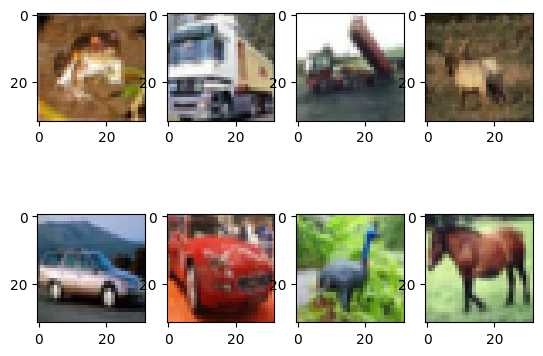

In [52]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

# 2. The predictive model

## 2.1 Baseline

In [55]:
start_time = time.time()

In [53]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [54]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

In [ ]:
end_time = time.time()
model_0_training_time = end_time - start_time
print("Baseline model training time: {} seconds".format(model_0_training_time))

Baseline model training time: 12.347363948822021 seconds


In [57]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

## 2.2 Model I

In [11]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [12]:
config = Namespace(image_height=32, image_width=32, num_channels=3, 
                   num_classes=10, n_layers=2, n_epochs=10)

In [29]:
class ImageClassifier:
    def __init__(self, image_height, image_width, num_channels, num_classes, n_layers):
        self.image_height = image_height
        self.image_width = image_width
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.model = self.build_model()
        
    def build_model(self):
        model = models.Sequential()
        
        for n in range(self.n_layers):
            model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.image_height, self.image_width, self.num_channels)))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Dropout(0.2))
            
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes,activation="softmax"))
        
        return model

In [34]:
# train: 40000 labels, val: 5000 labels, test: 5000 labels
x_train= imgs[10000:]/255
x_val= imgs[:5000]/255
x_test= imgs[5000:10000]/255

y_train= noisy_labels[10000:]
y_val= noisy_labels[:5000]
y_test = noisy_labels[5000:10000]

In [35]:
model_1 = ImageClassifier(config.image_height, config.image_width, 
                        config.num_channels, config.num_classes, config.n_layers).model

In [37]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()
history = model_1.fit(x_train, y_train, epochs=config.n_epochs, 
                    validation_data=(x_val, y_val))
end_time = time.time()

model_1_training_time = end_time - start_time
print("Model 1 training time: {} seconds".format(model_1_training_time))

Epoch 1/10
1250/1250 [==============================] - 44s 34ms/step - loss: 2.2912 - accuracy: 0.1240 - val_loss: 2.2709 - val_accuracy: 0.1576
Epoch 2/10
1250/1250 [==============================] - 44s 36ms/step - loss: 2.2676 - accuracy: 0.1579 - val_loss: 2.2486 - val_accuracy: 0.2050
Epoch 3/10
1250/1250 [==============================] - 45s 36ms/step - loss: 2.2531 - accuracy: 0.1770 - val_loss: 2.2349 - val_accuracy: 0.2138
Epoch 4/10
1250/1250 [==============================] - 44s 36ms/step - loss: 2.2422 - accuracy: 0.1898 - val_loss: 2.2300 - val_accuracy: 0.2046
Epoch 5/10
1250/1250 [==============================] - 45s 36ms/step - loss: 2.2346 - accuracy: 0.1933 - val_loss: 2.2241 - val_accuracy: 0.2232
Epoch 6/10
1250/1250 [==============================] - 52s 42ms/step - loss: 2.2298 - accuracy: 0.2008 - val_loss: 2.2206 - val_accuracy: 0.2222
Epoch 7/10
1250/1250 [==============================] - 52s 41ms/step - loss: 2.2251 - accuracy: 0.2004 - val_loss: 2.2201 -

In [38]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    class_prob = model_1.predict(np.array([image])/225)
    return np.argmax(class_prob, axis = -1)

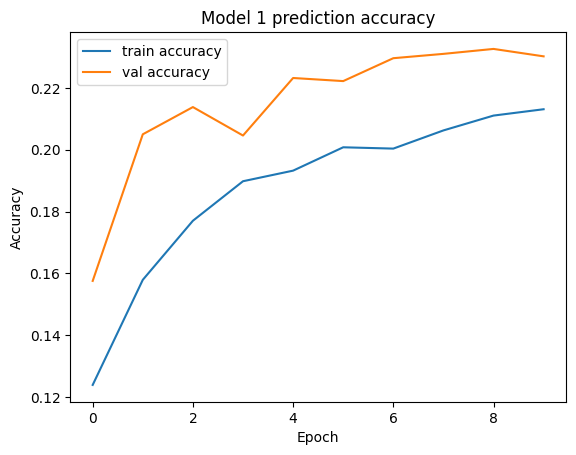

157/157 - 2s - loss: 2.2299 - accuracy: 0.2174 - 2s/epoch - 13ms/step


In [39]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model 1 prediction accuracy")
plt.legend()
plt.show()

test_loss, test_acc = model_1.evaluate(x_test, y_test, verbose=2)

## 2.3. Model II

In [25]:
edited_labels = pd.read_csv('edited_labels.csv',header=None, delimiter=',', dtype="int8").to_numpy().flatten()

In [27]:
# train: 40000 labels, val: 5000 labels, test: 5000 labels
x_train= imgs[10000:]/255
x_val= imgs[:5000]/255
x_test= imgs[5000:10000]/255

y_train= edited_labels[10000:]
y_val= edited_labels[:5000]
y_test = edited_labels[5000:10000]

In [30]:
model_2 = ImageClassifier(config.image_height, config.image_width, 
                        config.num_channels, config.num_classes, config.n_layers).model

In [31]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()
history = model_2.fit(x_train, y_train, epochs=config.n_epochs, 
                    validation_data=(x_val, y_val))
end_time = time.time()

model_2_training_time = end_time - start_time
print("Model 2 training time: {} seconds".format(model_2_training_time))

Epoch 1/10


C:\Users\Brendan\anaconda3\envs\colab_env\lib\site-packages\keras\backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


1250/1250 [==============================] - 35s 27ms/step - loss: 1.6597 - accuracy: 0.3973 - val_loss: 1.5578 - val_accuracy: 0.4552
Epoch 2/10
1250/1250 [==============================] - 39s 31ms/step - loss: 1.3330 - accuracy: 0.5227 - val_loss: 1.3756 - val_accuracy: 0.5062
Epoch 3/10
1250/1250 [==============================] - 35s 28ms/step - loss: 1.2377 - accuracy: 0.5566 - val_loss: 1.3846 - val_accuracy: 0.5136
Epoch 4/10
1250/1250 [==============================] - 35s 28ms/step - loss: 1.1748 - accuracy: 0.5815 - val_loss: 1.3021 - val_accuracy: 0.5470
Epoch 5/10
1250/1250 [==============================] - 36s 29ms/step - loss: 1.1334 - accuracy: 0.5970 - val_loss: 1.2943 - val_accuracy: 0.5528
Epoch 6/10
1250/1250 [==============================] - 38s 30ms/step - loss: 1.1071 - accuracy: 0.6075 - val_loss: 1.2440 - val_accuracy: 0.5778
Epoch 7/10
1250/1250 [==============================] - 41s 33ms/step - loss: 1.0693 - accuracy: 0.6203 - val_loss: 1.3115 - val_accura

In [40]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    class_prob = model_2.predict(np.array([image])/225)
    return np.argmax(class_prob, axis = -1)

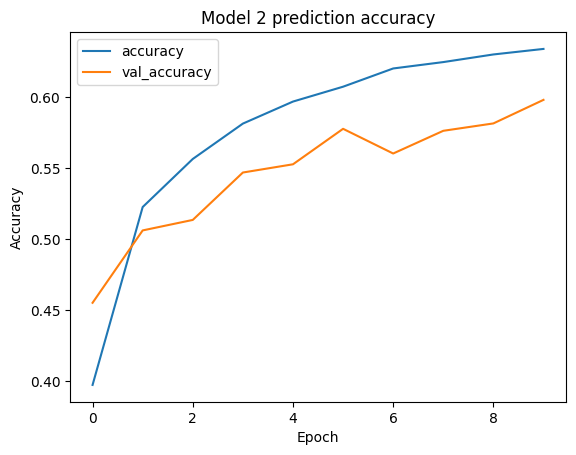

157/157 - 2s - loss: 1.3522 - accuracy: 0.5482 - 2s/epoch - 11ms/step


In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model 2 prediction accuracy")
plt.legend()
plt.show()

test_loss, test_acc = model_2.evaluate(x_test, y_test, verbose=2)

# 3. Evaluation

In [41]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [60]:
test_imgs = imgs[0:1000]
test_labels = clean_labels[:1000]

start_time = time.time()
evaluation(baseline_model, test_labels, test_imgs)
end_time = time.time()

model_0_evaluation_time = end_time - start_time
print("Baseline model evaluation time: {} seconds".format(model_0_evaluation_time))

              precision    recall  f1-score   support

           0       0.32      0.45      0.37       102
           1       0.18      0.25      0.21       112
           2       0.24      0.05      0.08        99
           3       0.23      0.15      0.18        92
           4       0.26      0.52      0.34        99
           5       0.18      0.12      0.14        85
           6       0.28      0.36      0.31       107
           7       0.55      0.06      0.11       102
           8       0.27      0.44      0.34        99
           9       0.23      0.12      0.15       103

    accuracy                           0.25      1000
   macro avg       0.27      0.25      0.22      1000
weighted avg       0.27      0.25      0.23      1000

Baseline model evaluation time: 0.32712483406066895 seconds


In [50]:
# (model_I, test_labels, test_imgs)
# (model, test_labels, test_imgs):
start_time = time.time()
y_true = clean_labels[:1000]
y_pred = []
for image in test_imgs[:1000]:
    y_pred.append(model_I(image))
print(classification_report(y_true, y_pred))
end_time = time.time()
model_1_evaluation_time = end_time - start_time
print("Model 1 evaluation time: {} seconds".format(model_1_evaluation_time))

1/1 [==============================] - 0s 97ms/step
              precision    recall  f1-score   support

           0       0.48      0.62      0.54       102
           1       0.53      0.67      0.59       112
           2       0.36      0.43      0.39        99
           3       0.27      0.24      0.25        92
           4       0.53      0.19      0.28        99
           5       0.33      0.54      0.41        85
           6       0.53      0.37      0.44       107
           7       0.67      0.47      0.55       102
           8       0.51      0.68      0.58        99
           9       0.60      0.41      0.49       103

    accuracy                           0.47      1000
   macro avg       0.48      0.46      0.45      1000
weighted avg       0.49      0.47      0.46      1000

Model 1 evaluation time: 121.68034863471985 seconds


In [51]:
# (model_I, test_labels, test_imgs)
# (model, test_labels, test_imgs):
start_time = time.time()
y_true = clean_labels[:1000]
y_pred = []
for image in test_imgs[:1000]:
    y_pred.append(model_II(image))
print(classification_report(y_true, y_pred))
end_time = time.time()
model_1_evaluation_time = end_time - start_time
print("Model 2 evaluation time: {} seconds".format(model_1_evaluation_time))

1/1 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       102
           1       0.57      0.81      0.67       112
           2       0.57      0.35      0.44        99
           3       0.58      0.12      0.20        92
           4       0.59      0.55      0.57        99
           5       0.37      0.79      0.50        85
           6       0.72      0.67      0.70       107
           7       0.72      0.59      0.65       102
           8       0.82      0.57      0.67        99
           9       0.53      0.56      0.55       103

    accuracy                           0.57      1000
   macro avg       0.60      0.57      0.55      1000
weighted avg       0.61      0.57      0.56      1000

Model 2 evaluation time: 111.0760931968689 seconds


In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

Model | Test Accuracy | Training time (sec) | Evaluation time (sec) 
:-------------------|:---------------:|--------------------:|--------------------:
Baseline model      | 0.25  | 12.34 | 0.327
Model 1      | 0.47  | 418.23 | 121.68
Model 2      | 0.57  | 383.81 | 111.08